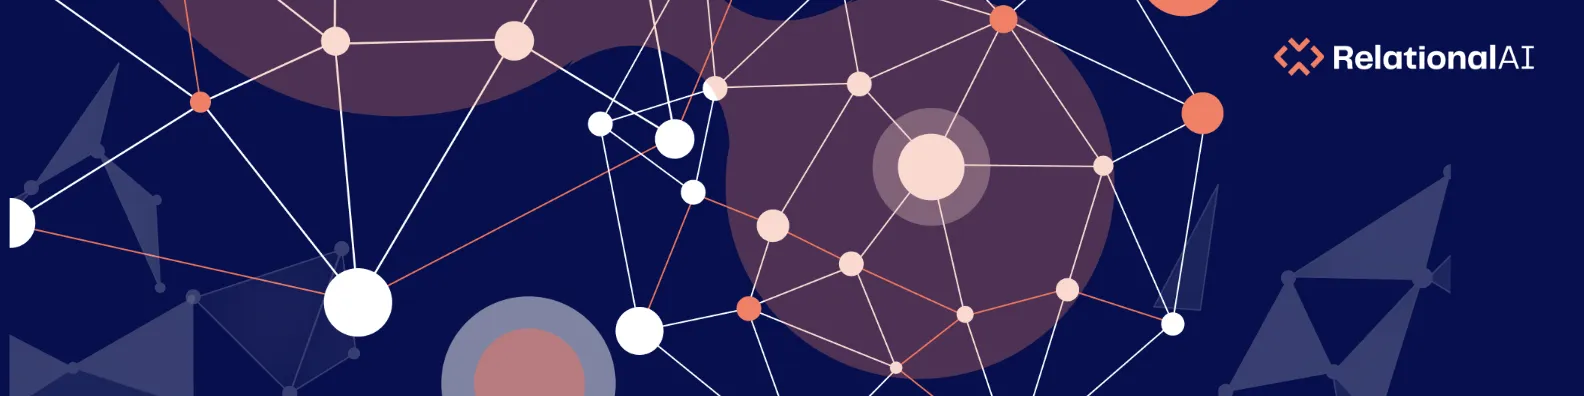

# Collaborative Filtering Recommender System Using RelationalAI

## Overview
In this notebook, we will explore how to utilize RelationalAI to build a recommendation system.

- Step 1: We convert user-item interactions to a bipartite graph.
- Step 2: We use user-item interactions to compute item-item by leveraging the  functions supported by the graph analytics library.
- Step 3: We use the similarities to predict the scores for all (user, movie) pairs. Each score is an indication of how likely it is for a user to interact with a movie.
- Step 4: We sort the scores for every user in order to generate top-k recommendations.
- Step 5: We evaluate performance using evaluation metrics that are widely used for recommender systems.


## What you will learn
- How to run all sorts of graph algorithms on our data, where it already lives, to discover new insights.
- How to visualize graphs.
- How thanks to native applications with Snowpark Container Services, we can do all of this within the Data Cloud!

***

## Let's get started!
We start by importing all the Python packages and modules that we will need.

In [1]:
import relationalai as rai
from relationalai.clients.snowflake import Snowflake
from relationalai.std import aggregates, alias
from relationalai.std.graphs import Graph

from IPython.display import Image

## Define Model in RelationalAI
Let's define our model object. **Models** represent collections of objects. **Objects**, like Python objects, have **types** and **properties**, which we will define in a bit.

In [2]:
model = rai.Model("recommendation_demo")

## Referencing Snowflake Data

In [3]:
Train = model.Type("TRAIN", source="RECOMMENDATION_DEMO.PUBLIC.TRAIN")
Test = model.Type("TEST", source="RECOMMENDATION_DEMO.PUBLIC.TEST")
MovieDetails = model.Type("MOVIE_DETAILS", source="RECOMMENDATION_DEMO.PUBLIC.MOVIE_DETAILS")

## Type Declarations

In [4]:
User = model.Type("User")
Movie = model.Type("Movie")
Similarity = model.Type("Similarity")
NearestNeighbors = model.Type("NearestNeighbors")
Scoring = model.Type("Scoring")
Recommendation = model.Type("Recommendation")

## Weaving data into our Model
It's time to start weave our data into our model. We do this by writing some rules. **Rules describe objects in a model and the relationships between them**.\
They are created using the `model.rule()` context manager.

### Defining User
This rule adds an object to the `User` type for each occurrence of a unique `user_id`. Let's run a query to see how many users we have in our dataset.

In [5]:
# Define User Type
with model.rule():
    t = Train()
    User.add(user_id=t.user_id)

# Check the total number of users
with model.query() as select:
    u = User()
    num_records = aggregates.count(u)
    result = select(num_records)

result

result
943


### Defining Movie
We do the same as we just did with User - but now for `Movie`.

In [6]:
# Define Movie Type
with model.rule():
    movie = MovieDetails()
    Movie.add(item_id=movie.item_id, title=movie.title)

# Check the total number of Movies
with model.query() as select:
    m = Movie()
    num_records = aggregates.count(m)
    result = select(num_records)

result

result
1682


Now, let's link users and movies

In [7]:
# Link Users to Movies
with model.rule():
    t = Train()
    u = User(user_id=t.user_id)
    m = Movie(item_id=t.item_id)
    u.watched.add(m)

## Graph Construction

The first step is to convert the input interactions data to a bipartite graph that contains two types of nodes: Users and Movies, as shown in the image below.

In [8]:
movie_graph = Graph(model, undirected=True)

In [9]:
# Add edges to the graph between users and movies / nodes will be added automatically
with model.rule():
    u = User()
    movie_graph.Edge.add(
        u,
        u.watched
    )

In [10]:
data = movie_graph.fetch()

num_nodes = len(data["nodes"])
num_edges = len(data["edges"])
print(f"Number of nodes: {num_nodes}, Number of edges: {num_edges}")

Number of nodes: 2593, Number of edges: 80000


## Similarity Computation

Now that we have modeled our data as a graph, we can compute item-item and user-user similarities using the user-item interactions:\
Movies that have been watched by the same users will have a high similarity value, while movies that have been watched by different users will have a low similarity value.


In [11]:
with model.rule():
    m1 = Movie()
    m2 = Movie()
    m1 != m2
    similarity_score = movie_graph.compute.cosine_similarity(m1, m2)

    Similarity.add(
        movie1=Movie(item_id=m1.item_id),
        movie2=Movie(item_id=m2.item_id),
        similarity_score=similarity_score,
    )

In [12]:
with model.query() as select:
    sim = Similarity()
    num_records = aggregates.count(sim.movie1.title, sim.movie2.title, sim.similarity_score)
    result = select(num_records)

result

result
1702905


## Nearest Neighbors

Now, we'll identify the top k nearest neighbor movies for each movie, determined by the similarity scores computed in the preceding section.

In [13]:
neighborhood_size = 20

In [14]:
with model.rule():
    sim = Similarity()
    # Find movies top k neighbors
    score_rank = aggregates.rank_desc(sim.similarity_score, per=[sim.movie1])
    score_rank <= neighborhood_size
    # Add objects to NearestNeighbors Type
    NearestNeighbors.add(
        movie=sim.movie1,
        nearest_movies=sim.movie2, 
        similarity_score=sim.similarity_score,
    )

In [15]:
def get_similar_movies(movie_title):
    """
    Retrieves similar movies to the given movie title, ranked by similarity score.
    """
    with model.query() as select:
        n = NearestNeighbors()
        n.movie.title == movie_title
        score_rank = aggregates.rank_desc(n.similarity_score, per=[n.movie])
        similar_movies = select(
            alias(score_rank, "Rank"), 
            alias(n.movie.title, "Movie "),
            alias(n.nearest_movies.title, "SimilarTo"),
            alias(n.similarity_score, "Score"),
        )
    return similar_movies

In [16]:
similar_movies = get_similar_movies("Titanic (1997)")
similar_movies.results.head()

,rank,movie,similarto,score
0,1,Titanic (1997),Good Will Hunting (1997),0.522906
1,2,Titanic (1997),Apt Pupil (1998),0.515218
2,3,Titanic (1997),Wag the Dog (1997),0.498406
3,4,Titanic (1997),Air Force One (1997),0.477172
4,5,Titanic (1997),Contact (1997),0.473483


## Scoring

#### Formula

To predict whether a user will watch a particular movie based on their past movie preferences using an item-based approach, we calculate the score for each (user, movie) pair.\
This score indicates the likelihood of a user watching a specific movie and is determined as follows:

$$\text{Score}_{u,i} = \sum_{n \in N[i] \cap W[u]} \text{Sim}_{i,n}$$

- $\text{Score}_{u,i}$ is the predicted score for user $u$ and item $i$.
- $N[i]$ is the set of nearest neighbors of item $i$.
- $W[u]$ is the set of items watched by user $u$.
- $\text{Sim}_{i,n}$ is the similarity score between items $i$ and $n$.

In [17]:
with model.rule():
    u = User()
    m = Movie()
    n = NearestNeighbors()

    # Remove movies already watched by users from scoring
    with model.not_found():
        m == u.watched
    # Find neighbors to m
    n.movie.item_id == m.item_id    
    # Get intersection between watched movies and neighbors to m
    n.nearest_movies == u.watched 
    score_sum = aggregates.sum(n.similarity_score, per=[n.movie])
    # Define Scoring type
    Scoring.add(
        user=u,
        movie=m,
        score=score_sum
    )

## Top-k Recommendations

To generate a list of k recommendations for a user, the last step is to rank all the scores for the particular user from highest to lowest, and then select the top k scoring movies.

In [18]:
k_recommendations = 10

In [19]:
with model.rule():
    s = Scoring()
    score_rank = aggregates.top(k_recommendations, s.score, s, per=[s.user])
    
    Recommendation.add(
        user=s.user,
        score_rank = score_rank,
        recommended_movie = s.movie,
        score = s.score
    )

## Evaluation

**Precision:**
Precision measures the accuracy of the positive predictions made by the recommendation system. \
In the context of recommendation systems, precision refers to the proportion of recommended items that are relevant to the user.\
Precision is calculated as:

$$
\text{Precision} = \frac{\text{Number of relevant items recommended}}{\text{Total number of recommended items}}
$$

Where:
- Number of relevant items recommended: The number of items in the recommendation list that the user actually finds relevant.
- Total number of recommended items: The total number of items recommended to the user.

In [20]:
# Link Users to Relevant Movies (Ground truth)
with model.rule():
    test = Test()
    u = User(user_id=test.user_id)
    m = Movie(item_id=test.item_id)
    u.relevant.add(m)

In [21]:
# Calculate Precision per User
with model.rule():
    u = User()
    r = Recommendation(user=u)

    # Count the number of recommended items that are relevant
    u.relevant == r.recommended_movie
    # Calculate precision for users
    true_positive = aggregates.count(u.relevant.item_id, per=[u.user_id])
    user_precision = true_positive / k_recommendations
    
    # Add user_precision as an attribute
    u.set(user_precision=user_precision)

In [22]:
# Show Average Precision
with model.query() as select:
    u = User()
    u.relevant.has_value()
    user_precision = u.user_precision.or_(0.0)
    total_precision = aggregates.avg(u, user_precision)
    precision = select(
        alias(total_precision, "Average Precision")
    )
precision

average precision
0.316993
